# Speeding up your code with Cython

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ziaeemehr/workshop_hpcpy/blob/main/notebooks/native-extentions/cython/Speeding%20up%20your%20code%20with%20Cython.ipynb)

<div class="dateauthor">
Credit: Jan H. Meinke
</div>

## Cython

> “Cython is a language that makes writing C extensions for the Python language as easy as Python itself”

Cython allows you to write C extensions to Python in a very pythonic manner. In this notebook we'll explore the syntax of Cython and see what kind of speed up we can achieve.

Cython provides an extension for Jupyter notebooks that makes working with Cython very convenient. If you enter `%load_ext Cython` the `%%cython` magic becomes available.

In [2]:
# !pip install Cython

In [3]:
%load_ext Cython

In [5]:
import numpy
import threadpoolctl # to monitor thread usage

Let us start with something simple. The following function calculates the dot product between two vectors:

In [6]:
def pydot(v, w):
    if len(v) == len(w) and len(v) > 0:
        res = v[0] * w[0]
        for i in range(1, len(v)):
            res += v[i] * w[i]
    return res

In [7]:
v = numpy.arange(0, 10000, dtype=int)
w = numpy.arange(0, 10000, dtype=int)

In [8]:
%%timeit a = range(10000); b = range(10000)
pydot(a, b)

1.31 ms ± 59.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
pydot_timing = %timeit -o pydot(v, w)

2.41 ms ± 46.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Elementwise access to NumPy arrays can in the meantime be just as fast as access for lists.

Now let us invoke Cython

In [12]:
%%cython
def dot(v, w):
    if len(v) == len(w) and len(v) > 0:
        res = v[0] * w[0]
        for i in range(1, len(v)):
            res += v[i] * w[i]
    return res

In [13]:
%%timeit a = range(10000); b = range(10000)
dot(a, b)

1.44 ms ± 35.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
dot1_timing = %timeit -o dot(v, w)

2.16 ms ± 39.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can check what Cython does by invoking the cell magic with the option `-a`.

In [15]:
%%cython -a
def dot(v, w):
    if len(v) == len(w) and len(v) > 0:
        res = v[0] * w[0]
        for i in range(1, len(v)):
            res += v[i] * w[i]
    return res

This produces an annotated listing. The darker the yellow, the more Python code is in that line. You can click on each line to see the C code that was generated for it. Go ahead and explore.

There are many references to Python objects and functions. Basically, you only save the overhead of interpreting. Let's see if we can do a little better.

## Declaring types

The arguments `v` and `w` are very general. If we know, however, that we are only going to pass ndarrays of integers, we can be more specific:

In [18]:
%%cython -a
import numpy
cimport numpy

def dot(numpy.ndarray[numpy.int64_t, ndim = 1] v, numpy.ndarray[numpy.int64_t, ndim = 1] w):
    cdef long res = 0
    if len(v) == len(w) and len(v) > 0:
        res = v[0] * w[0]
        for i in range(1, len(v)):
            res += v[i] * w[i]
    return res

I also added ``cdef long res = 0``. This declares a C variable. C variables are not visible to a Python program. Here this doesn't matter since res is only used within the function.

In [19]:
dot2_timing = %timeit -o dot(v, w)

10.9 μs ± 80.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Note that ``cdef long res = 0`` is white. It's translated directly into C. `len(v)` is a Python call. It can be pulled out and assigned to an integer variable.

In [21]:
%%cython -a
import numpy as np
cimport numpy as np

def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res = 0
    cdef int n = 0
    n = len(v)
    if n > 0 and n == len(w):
        for i in range(0, n):
            res += v[i] * w[i]
    return res

In [22]:
dot3_timing = %timeit -o dot(v, w)

9.85 μs ± 445 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


If you look at line 10, you'll notice that there are some bounds checks, but they are unnecessary since we check the bounds beforehand already. Let's do away with them.

## Skipping checks

In [23]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False)
def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res
    cdef int i
    cdef int n
    n = len(v)
    if n > 0 and n == len(w):
        res = v[0] * w[0]
        for i in range(1, n):
            res += v[i] * w[i]
        return res

In [24]:
dot4_timing = %timeit -o dot(v,w)

8.16 μs ± 144 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


We can dispense of wraparound a[-1]->a[len(a)-1], too.

In [25]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res
    cdef int i
    cdef int n
    n = len(v)
    if n > 0 and n == len(w):
        res = v[0] * w[0]
        for i in range(1, n):
            res += v[i] * w[i]
        return res

In [26]:
dot5_timing = %timeit -o dot(v,w)

7.72 μs ± 78.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Adding compiler option
### Cython magic

In [27]:
%%cython --compile-args=-O2 --compile-args=-march=native --compile-args=-w --force 
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res
    cdef int i
    cdef int n
    n = len(v)
    if n > 0 and n == len(w):
        res = 0
        for i in range(0, n):
            res += v[i] * w[i]
        return res

Sometimes we need (or want) to pass some options to the compiler. The cython magic can take compile-args and link-args that are passed to the underlying compiler. Later, we'll show you how to integrate all of this in a setup.py script to compile your extension outside of a notebook.

The [documentation shows you, which options can be passed to the magic command](https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiling-with-a-jupyter-notebook).

In [28]:
dot5a_timing = %timeit -o -r 13 dot(v,w)

7.81 μs ± 189 ns per loop (mean ± std. dev. of 13 runs, 100,000 loops each)


### Adding OpenMP

Since Cython generates compiled Python extensions, we can release the GIL and run things in parallel if we don't make calls to the Python API.

As we've seen our inner loop is free of any Python calls (the annotated code is white). Since OpenMP supports reductions, we can parallelize the loop using Cython's ``prange``. Within ``prange`` we have to explicitely release the GIL by setting ``nogil=True``. We also need to pass the compiler and linker flags for OpenMP.

In [29]:
%%cython  --compile-args=-fopenmp --compile-args=-O2 --compile-args=-march=native --compile-args=-w --link-args=-fopenmp --force
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)
def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res
    cdef int i
    cdef int n
    n = len(v)
    if n > 0 and n == len(w):
        res = v[0] * w[0]
        for i in prange(1, n, nogil=True):
            res += v[i] * w[i]
        return res

In [31]:
# Let's limit the number of threads we use since the overhead for 256 threads would 
# kill any chance of improved performance. You can play around with the number.
with threadpoolctl.threadpool_limits(16):
    dot6_timing = %timeit -o dot(v,w)

5.88 μs ± 151 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Our data set is too small to benefit from parallelization. The overhead due to starting multiple threads is too large for this problem size.

## Function declaration with def, cdef, and cpdef

In short, functions defined using **def** are visible from Python and treated like Python functions even within Cython. Functions defined with **cdef** are C functions and are not visible from Python at all. Functions declared with **cpdef** are C functions that can be called efficiently from within Cython but also have a Python wrapper so they can be accessed from Python.

#### Exercise
* Define a function `add` in Cython using `cdef` that takes two float values as arguments and returns the sum. 
* Try calling it from outside Cython

In [ ]:
# Write your function here


Now use cpdef instead.

In [ ]:
# Copy the function from above and use cpdef instead of cdef

## Building a Cython extension outside of a notebook

So far we have used IPython and the Cython magic to build and test our extension within a notebook. Once we are satisfied and want to put our extension in production, we want to be able to build the extension without IPython. The recommended way to do that is to use `distutils` and a `setup.py` file.

Note that distutils has been marked as deprecated as of Python 3.10, but we are still using Python 3.9.x on our systems.

### A simple setup.py file

```python
from distutils.core import setup
from Cython.Build import cythonize
setup(name="Sum of integers",
      ext_modules=cythonize("sum.pyx"),
      zip_safe=False
     )
```

### Adding compiler options 

To add compiler options, for example, to compile with OpenMP, we need to set up an Extension first. Then, we use the Extension instead of the file name in the setup function. Our new setup.py file now looks like this:

```python
from distutils.core import setup
from distutils.extension import Extension
from Cython.Build import cythonize

ext_modules = [
    Extension("sum",
              ["sum.pyx"],
              extra_compile_args = ["-fopenmp"],
              extra_link_args = ["-fopenmp"]
             )
]
setup(name="Sum of integers",
      ext_modules=cythonize(ext_modules),
      zip_safe=False
     )
```

**Exercise:** Take the Cython code that defines dot using `prange` in [Adding OpenMP](#Adding-OpenMP) and write it to `dot.pyx` using the `%%writefile` magic. Make sure to comment out the `cython magic`. Take the above code for setup.py and copy it into a file called `setup.py`. Change the setup.py code to build a module named dot and use `dot.pyx`. Then build the extension in a terminal window with the command. **Note:** Make sure our environment is loaded `source hpcpy21`.

```bash
python setup.py build_ext --inplace
```

If the build fails with `#include "numpy/arrayobject.h" not found`, you need to add the include path for numpy. Luckily, numpy has a function for that: `numpy.get_include()`. Add the include path to the extra_compile_args. Include paths are added using `-I/path/to/be/included`. Since `setup.py` is a Python script you can call `numpy.get_include()` in the script and don't have to hardcode the path.

Write a test program that loads and tests the extension. Add a doc string to the dot function and include an example section like this:

```python
def dot(...):
""" Add description and parameters ...

Examples
--------
>>> import numpy
>>> from dot import dot
>>> v = numpy.arange(0, 10, dtype=int)
>>> w = numpy.arange(0, 10, dtype=int)
>>> print(dot(v, w))
285

"""
```

Rebuild the extension and run [doctest](https://docs.python.org/3.6/library/doctest.html) (`python -m doctest -v dot.pyx`). Without `-v` only failed tests are reported.

### Comparison with Numba

Numba, can generate fast functions, too.

In [32]:
from numba import int64, jit
@jit(nopython=True)
def udot(v, w):
    res = 0
    for i in range(0, len(v)):
        res += v[i] * w[i]
    return res

In [33]:
from numba import int64, jit
@jit(nopython=False)
def udotg(v, w):
    res = 0
    for i in range(0, len(v)):
        res += v[i] * w[i]
    return res

In [34]:
numbadot_timing = %timeit -o udot(v,w)

The slowest run took 4.70 times longer than the fastest. This could mean that an intermediate result is being cached.
8.3 μs ± 6.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
numbadotg_timing = %timeit -o udotg(v,w)

4.12 μs ± 213 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [38]:
%%timeit a = list(range(10000)); b = list(range(10000))
udotg(a,b)

19.6 ms ± 316 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
npdot_timing = %timeit -o np.dot(v,w)

9.56 μs ± 487 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [40]:
import numpy as np

tunits = {'ns':10**-9, 'us':10**-6, 'ms':10**-3, 's':1.0}
timers = [pydot_timing, dot1_timing, dot2_timing, dot3_timing, dot4_timing, dot5_timing, 
         dot6_timing, numbadot_timing, numbadotg_timing, npdot_timing]
times = np.array([t.best for t in timers])

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

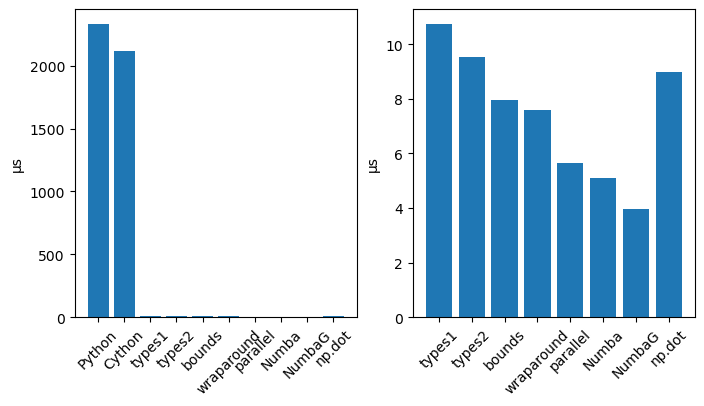

In [44]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.bar(np.arange(len(times)) + 1, times * 1e6)
plt.ylabel(u"µs")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],["Python", "Cython", "types1", "types2", "bounds", "wraparound", "parallel", 
                                  "Numba", "NumbaG", "np.dot"], rotation=45)
plt.subplot(1,2,2)
plt.bar(np.arange(2, len(times[2:]) + 2) + 1, times[2:] * 1e6)
plt.ylabel(u"µs")
plt.xticks([3, 4, 5, 6, 7, 8, 9, 10],["types1", "types2", "bounds", "wraparound", "parallel", 
                                  "Numba", "NumbaG", "np.dot"], rotation=45);

Finally, let's compare the performance for a larger data set. Remember the last version of our dot function uses OpenMP.

In [45]:
v = np.arange(10000000, dtype=int)
w = np.arange(10000000, dtype=int)
%timeit -n 1 pydot(v,w)
with threadpoolctl.threadpool_limits(16):
    %timeit dot(v,w)
%timeit udot(v,w)
%timeit np.dot(v,w)

/tmp/ipykernel_1811007/4200693014.py:5: RuntimeWarning: overflow encountered in scalar add
  res += v[i] * w[i]


2.46 s ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.36 ms ± 897 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.36 ms ± 897 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.1 ms ± 182 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.1 ms ± 182 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 75.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 75.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Cython and classes

Sometimes, we want to do more than just wrap a function. We might want an efficient data type that implements some operators, for example. For this Cython allows us to declare classes just like in Python:

In [46]:
%%cython
class Point:
    """A simple class representing a point in the x-y plane."""
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __repr__(self):
        return "(%.1f, %.1f)" % (self.x, self.y)

In [47]:
p = Point(0,1)

In [48]:
print(p)

(0.0, 1.0)


### Extension types

There is a second type of classes called *[extension types](http://cython.readthedocs.io/en/latest/src/userguide/extension_types.html)*. An extension type stores its members and methods in a C struct instead of a Python dictionary. This makes them more efficient but also more restrictive. Let's look at an example:

In [49]:
%%cython
from math import sqrt,asin,pi

cpdef double rad2deg(double alpha):
    return 180 * alpha / pi

cdef class Point:
    """A point in 2d."""
    cdef double x, y

    cdef double distance2origin(Point self):
        return sqrt(self.x * self.x + self.y * self.y)
    
    cdef alpha(Point self):
        return asin(self.y / self.distance2origin())
    
    def __cinit__(self, t_x, t_y):
        self.x = t_x
        self.y = t_y
    
    def __repr__(self):
        return "(r=%.2f, alpha=%.2f°)" % (self.distance2origin(), rad2deg(self.alpha()))

The first thing to note is the definition using `cdef class`. It's the reason extension types are also referred to as cdef classes. We can define functions that are only visible to C using `cdef` and Python functions using `def` (or both at once with `cpdef`). For functions defined with `cdef`, we need to give the type of self as well as a return type.

We can use the new class as follows:

In [50]:
p = Point(0.5, 1)
print(p)

(r=1.12, alpha=63.43°)


### Exercise

Try which methods of Point you can call.

## Cython Tutorial at SciPy

The following video is from a half-day tutorial on Cython.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("gMvkiQ-gOW8")